In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import random

from PIL import Image, ImageDraw

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

# Visualize some samples

In [2]:
image_path = 'carpet/test/hole/000.png'
image = Image.open(image_path).resize((224,224))


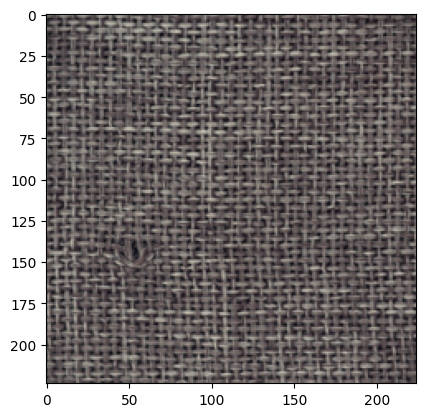

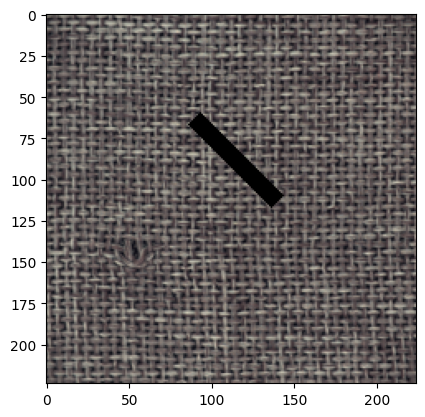

In [3]:
image_path = 'carpet/test/hole/000.png'
image = Image.open(image_path)
image = image.resize((224,224))
plt.imshow(image)
plt.show()

def apply_random_drawing(input_image):
    # Create a drawing object
    draw = ImageDraw.Draw(input_image)

    # Randomly choose one of the drawings
    drawing_choices = ['ellipse', 'rectangle', 'line']
    chosen_drawing = random.choice(drawing_choices)

    # Random position and size
    width, height = input_image.size
    x1 = random.randint(0, width-60)
    y1 = random.randint(0, height-60)
    x2 = x1+50
    y2 = y1+50

    # Apply the chosen drawing with random parameters
    if chosen_drawing == 'ellipse':
        draw.ellipse((x1, y1, x2, y2), fill=(0, 0, 0), outline=(0, 0, 0))
    elif chosen_drawing == 'rectangle':
        draw.rectangle((x1, y1, x2, y2), fill=(0, 0, 0), outline=(0, 0, 0))
    elif chosen_drawing == 'line':
        draw.line((x1, y1, x2, y2), fill=(0, 0, 0), width=10)

    return input_image

# Example usage

result_image = apply_random_drawing(image)
plt.imshow(result_image)

In [4]:
class Augmentation_Train_Dataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        train_path = Path(root_dir)
        self.transform = transform
        self.file_names = [str(pth) for pth in train_path.iterdir()]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.file_names[idx]
        image = Image.open(img_path).resize((224,224))

        augmentation = random.choice([True, False])

        if augmentation:
            aug_image = apply_random_drawing(image)
        else:
            aug_image = image
        if self.transform:
            aug_sample = self.transform(aug_image)
            sample = self.transform(image)

        return aug_sample,sample

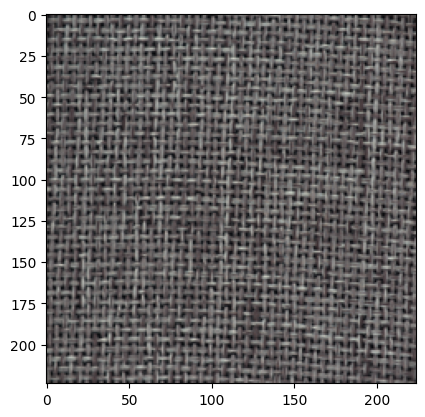

In [5]:
from torchvision.transforms import transforms

# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([transforms.ToTensor()])          # Convert the image to a PyTorch tensor and divide by 255.0

good_dataset = Augmentation_Train_Dataset(root_dir='carpet/train/good', transform=transform)

plt.imshow(good_dataset[0][0].permute(1, 2, 0))


# Train test split for the autoencoder

In [6]:

# Split the dataset into training and testing subsets
# The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
# The first argument `good_dataset` is the dataset to be split
# The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for testing.
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Print the lengths of the original dataset, training subset, and testing subset
print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 280
Number of samples in the training subset: 224
Number of samples in the testing subset: 56


## Using dataloader for efficient data loading during training

In [7]:
import torch
from torch.utils.data import DataLoader

# Assuming train_dataset and test_dataset are PyTorch datasets containing image data and labels

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
aug_image_batch, image_batch = next(iter(train_loader))

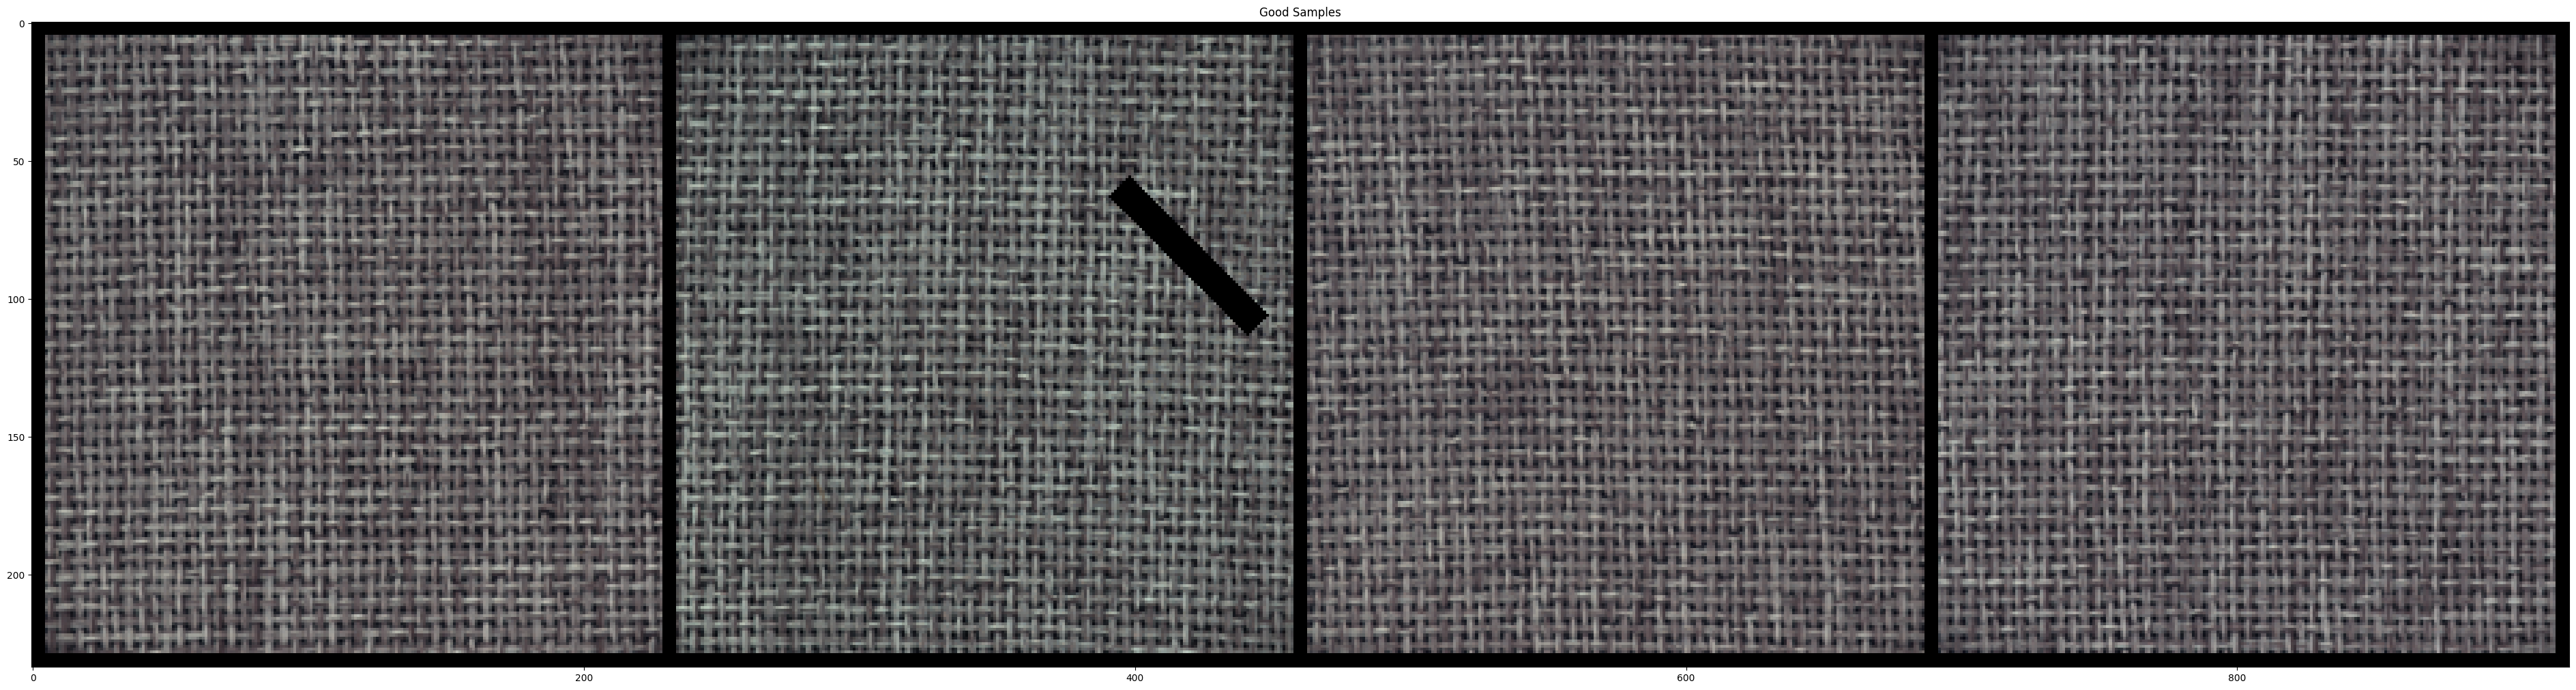

In [8]:
# Set the figure size
plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(aug_image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions to (height, width, channels) for visualization
plt.title('Good Samples')  # Set the title of the plot
plt.show()  # Show the plot

# Train autoencoder model

In [9]:


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()  
input_image = torch.randn(1, 3, 224, 224)  # Sample input image
output_image = model(input_image)
print(output_image.shape)  # Print the shape of the output image


torch.Size([1, 3, 224, 224])


In [111]:
# ckpoints = torch.load('autoencoder_augmented_images_l2_loss.pth')
# model.load_state_dict(ckpoints)

In [11]:
# Define the loss function and optimizer

model.cuda()# Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# Training loop

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.0154, Validation Loss: 0.0153
Epoch [10/100], Loss: 0.0150, Validation Loss: 0.0145
Epoch [15/100], Loss: 0.0113, Validation Loss: 0.0109
Epoch [20/100], Loss: 0.0083, Validation Loss: 0.0078
Epoch [25/100], Loss: 0.0071, Validation Loss: 0.0070
Epoch [30/100], Loss: 0.0067, Validation Loss: 0.0064
Epoch [35/100], Loss: 0.0064, Validation Loss: 0.0061
Epoch [40/100], Loss: 0.0062, Validation Loss: 0.0059
Epoch [45/100], Loss: 0.0058, Validation Loss: 0.0058
Epoch [50/100], Loss: 0.0058, Validation Loss: 0.0055
Epoch [55/100], Loss: 0.0055, Validation Loss: 0.0054
Epoch [60/100], Loss: 0.0052, Validation Loss: 0.0052
Epoch [65/100], Loss: 0.0052, Validation Loss: 0.0051
Epoch [70/100], Loss: 0.0054, Validation Loss: 0.0050
Epoch [75/100], Loss: 0.0050, Validation Loss: 0.0049
Epoch [80/100], Loss: 0.0048, Validation Loss: 0.0048
Epoch [85/100], Loss: 0.0051, Validation Loss: 0.0048
Epoch [90/100], Loss: 0.0050, Validation Loss: 0.0046
Epoch [95/100], Loss: 0.0045,

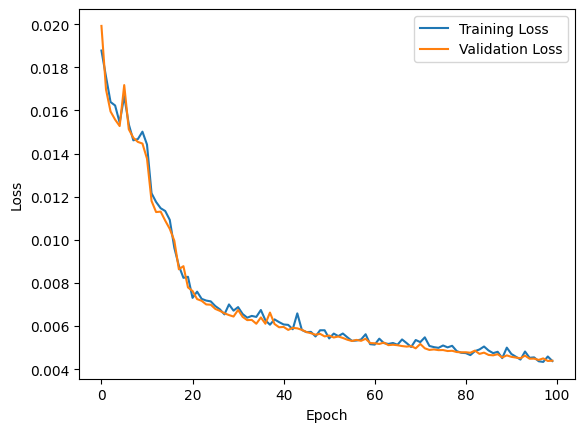

In [12]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for aug_img,img in train_loader:
        img = img.cuda()
        aug_img = aug_img.cuda()
        
        output = model(aug_img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients. 
    Loss.append(loss.item())
       

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for aug_img,img in test_loader:
            img = img.cuda()
            aug_img = aug_img.cuda()

            output = model(aug_img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
        

In [10]:
# Save the model
# torch.save(model.state_dict(), 'augmented_autoencoder_l2_loss.pth')
# model.eval()

ckpoints = torch.load('augmented_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)
model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

## Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

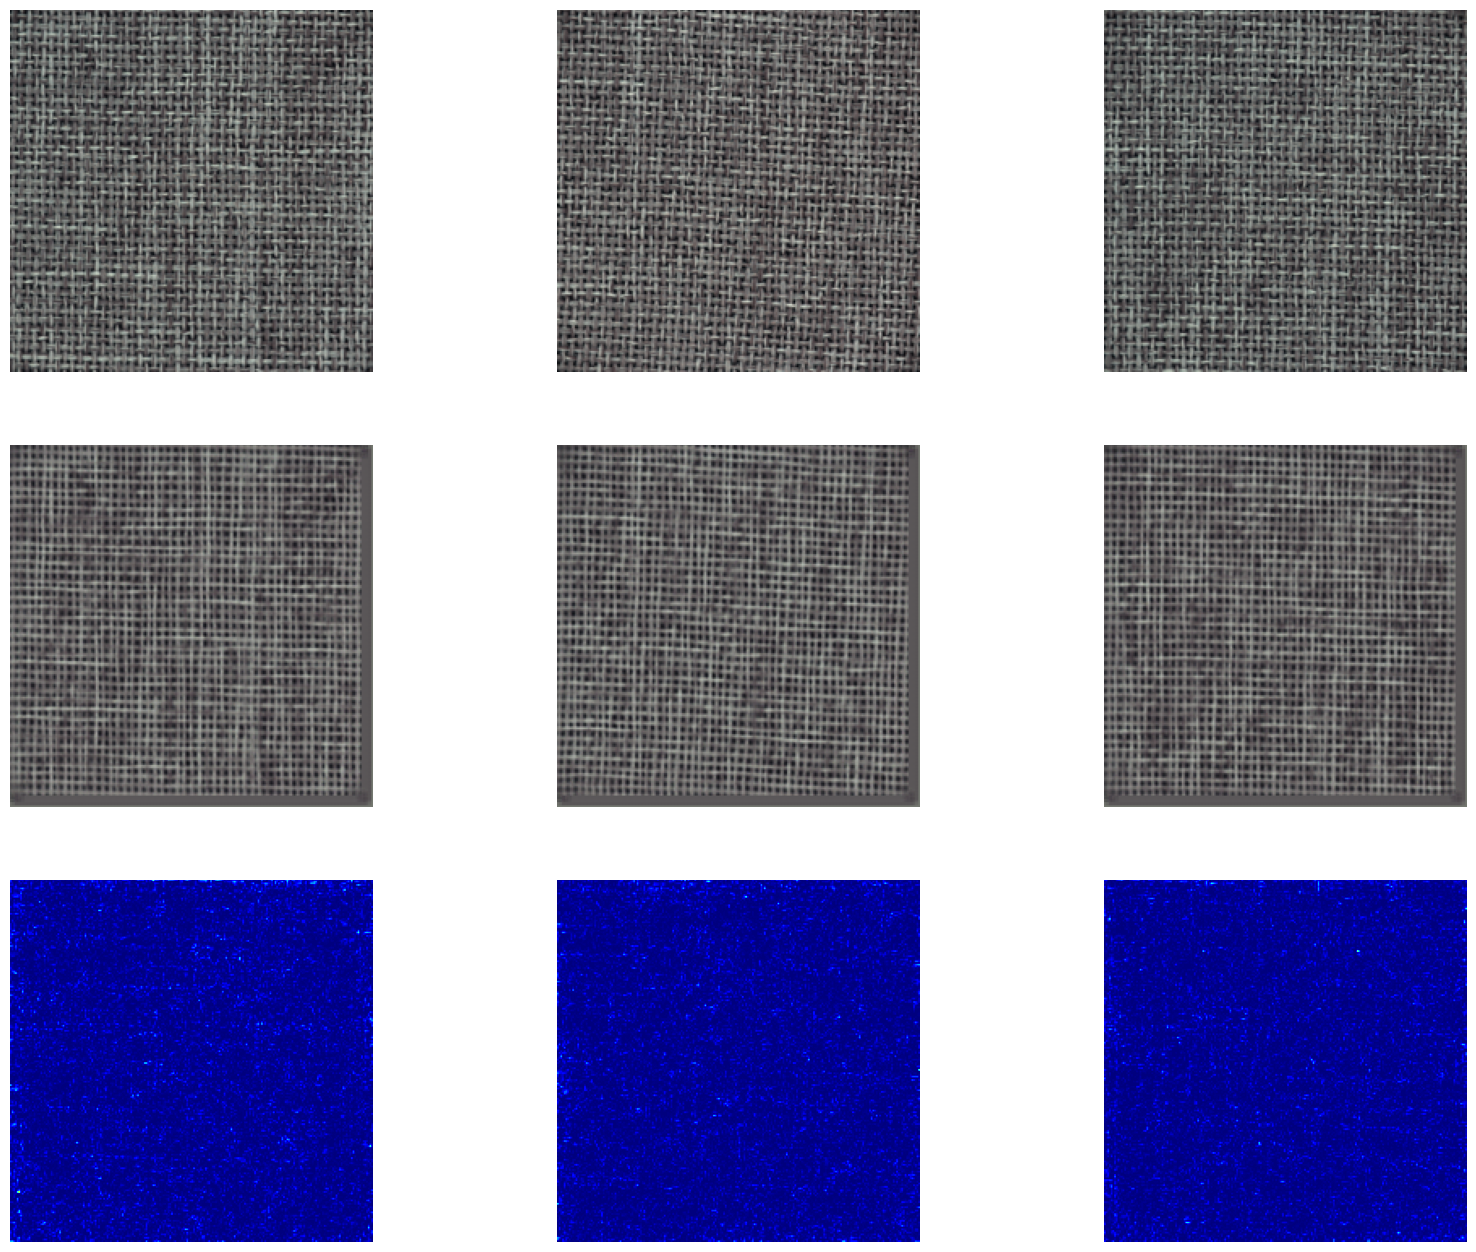

In [133]:
model.eval()

with torch.no_grad():
    for _, data in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Reconstruction of bad images

# Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

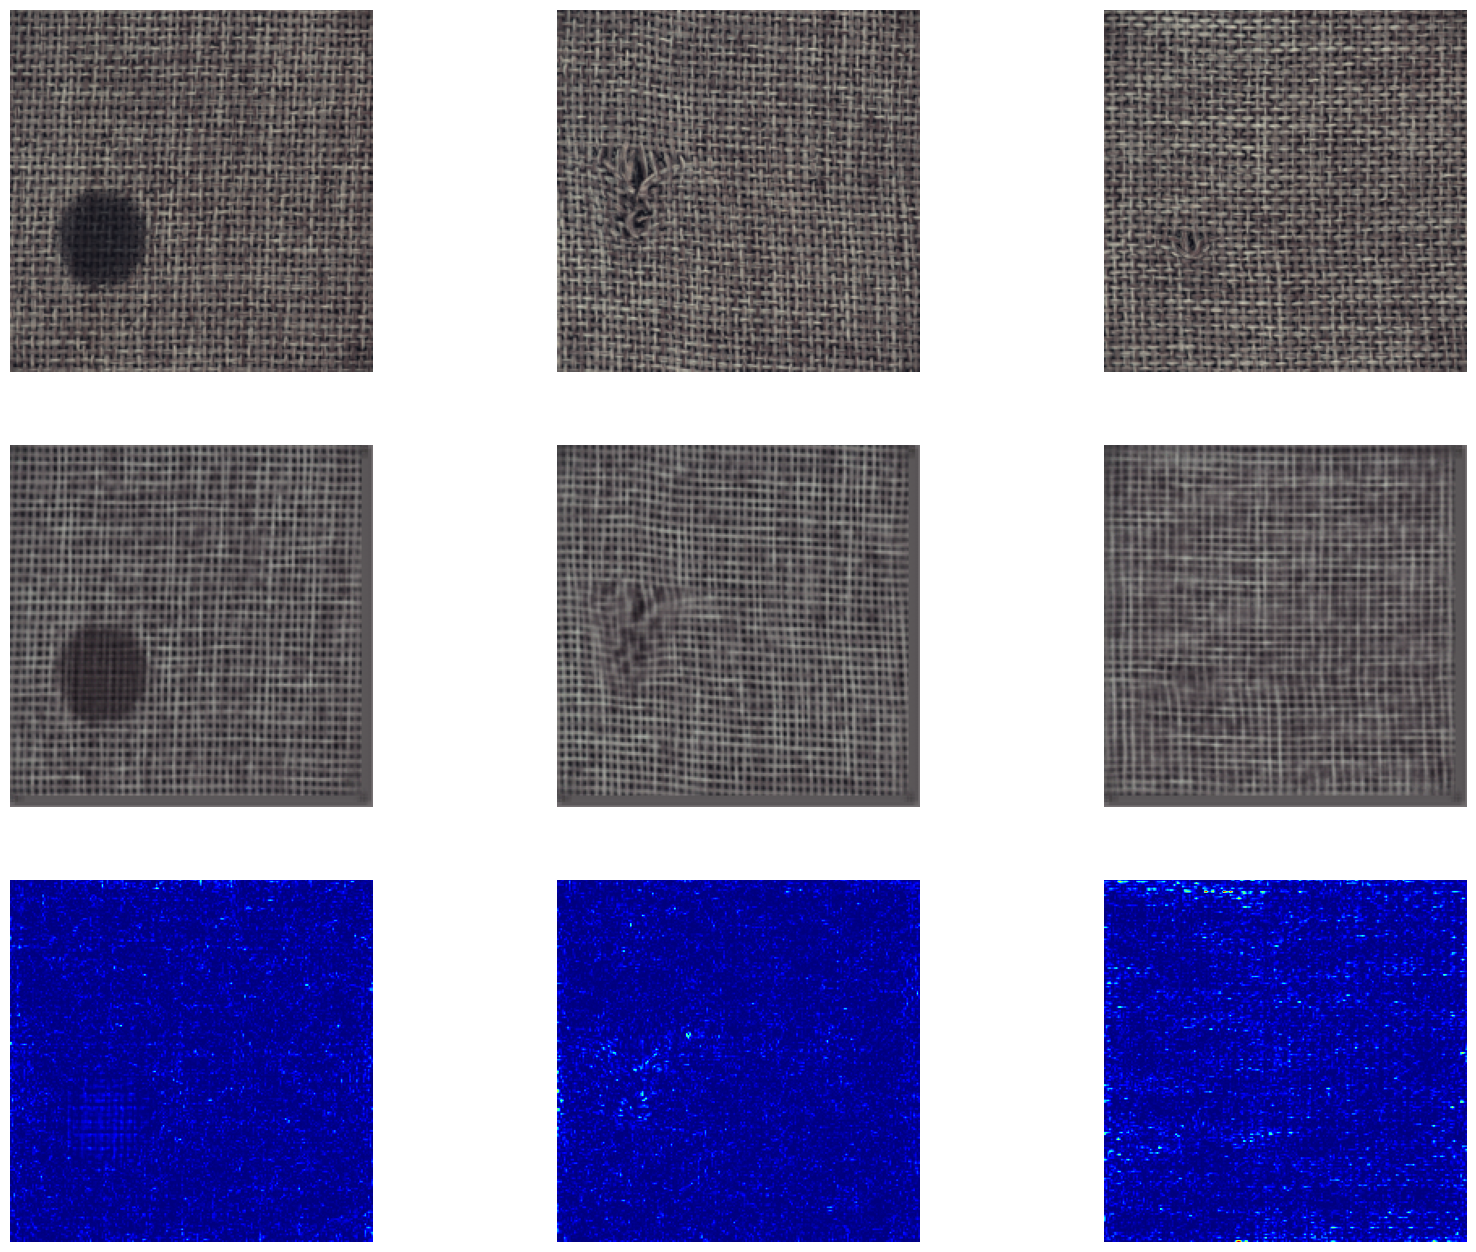

In [12]:
test_image_1 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\color\000.png').resize((224,224)))
test_image_2 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\cut\000.png').resize((224,224)))
test_image_3 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\hole\000.png').resize((224,224)))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)
    
recon_error =  ((data-recon)**2).mean(axis=1)
    
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()
# 

# Obtain the fault detection accuracy

In [13]:
RECON_ERROR=[]
with torch.no_grad():
    for _, data in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))
        
        RECON_ERROR.append(data_recon_squared_mean)
        
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

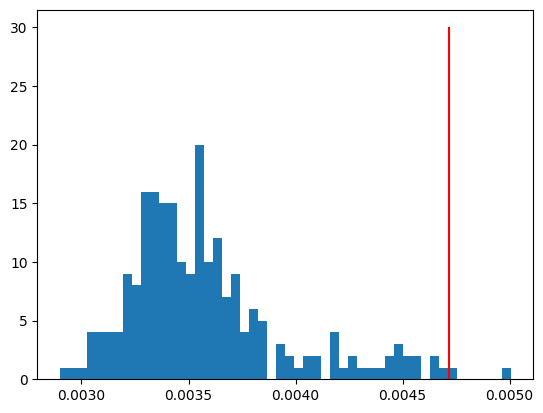

In [14]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r') 
plt.show()

In [15]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('carpet/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path).resize((224,224))).cuda().unsqueeze(0)
        recon_image = model(test_image)
        
        # y_score_image = 
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()
    
        y_pred_image = 1*(y_score_image >= best_threshold)
        
        y_true_image = 0 if fault_type == 'good' else 1
        
        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
    

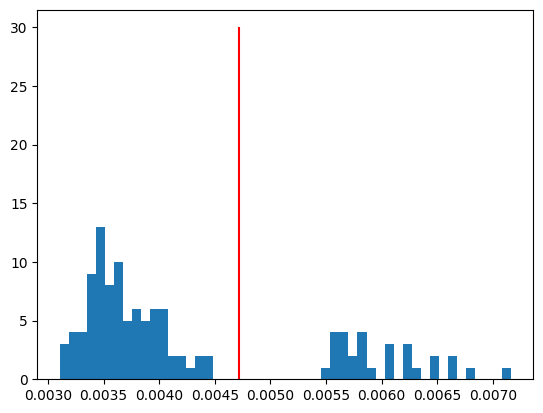

In [16]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.4117174959871589


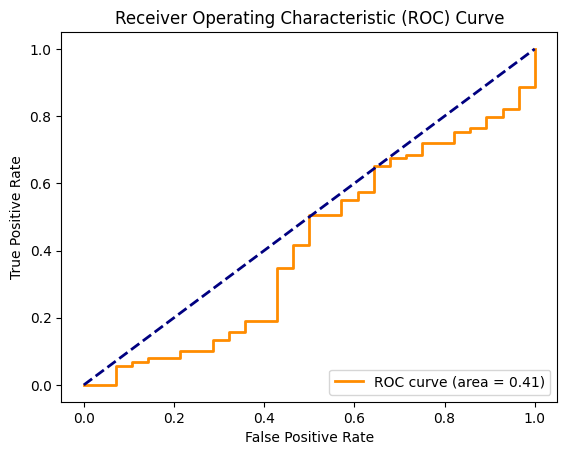

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

